# 1. 이상의 종류

1) Point Anomaly: 하나의 데이터가 나머지에 대해 이상하다고 판단되는 경우, 흔히 Outlier라고 부름
2) Collective Anomaly: 데이터셋 내에 여러 데이터 포인트가 이상하다고 판단되는 경우
3) Contextual Anomal: 전체적인 데이터셋의 맥락을 고려했을 때 이상하다고 판단되는 경우

# 2. Isolation Forest

기본적으로 데이터셋을 Decision Tree 형태로 표현해, 
- 정상값을 분리하기 위해서는 의사결정나무를 깊숙하게 타고 내려가 분류
- 이상값을 분리하기 위해서는 의사결정나무 상단부에서 분리할 수 있다는 것을 이용

이 특성을 이용해 의사결정나무를 몇 회 타고 내려가야 분리되는가를 기준으로 정상과 이상을 분류.

Isolation Forest의 장점
- 군집기반의 이상탐지 알고리즘에 비해 계산량이 매우 적음
- 강건한(Robust)한 모델을 만들 수 있다. <- 이상치 등에 크게 영향을 받지 않는 모델

# 3. 예제 살펴보기

### 1) 가장 단순한 예제

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.ensemble import IsolationForest

In [25]:
rng = np.random.RandomState(42)

# Generating training data
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])

# Generating new, 'normal' observation
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])

# Generating outliers
X_outliers = rng.uniform(low = -1, high = 5, size = (50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

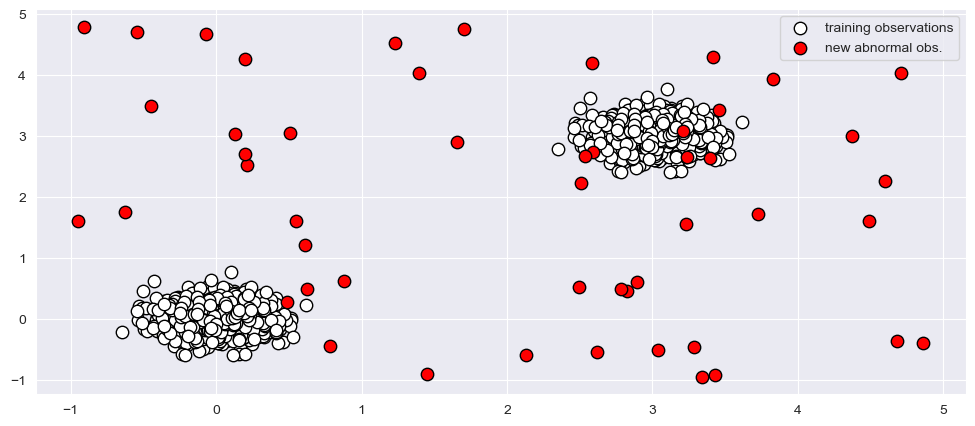

In [29]:
plt.figure(figsize = (12,5))

p1 = plt.scatter(X_train.x1, X_train.x2, c = 'white', s = 20*4, edgecolor = 'k', label = 'training observations')
p2 = plt.scatter(X_outliers.x1, X_outliers.x2, c = 'red', s = 20*4, edgecolor = 'k', label = 'new abnormal obs.')
plt.legend(loc = 'best')

In [31]:
# Modeling
clf = IsolationForest(max_samples = 100, contamination = 0.1, random_state = 42)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

C:\Anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


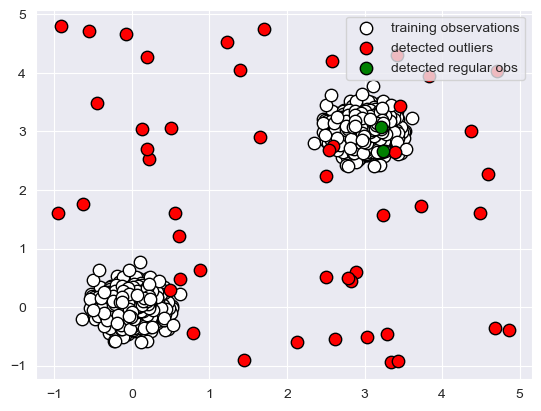

In [32]:
X_outliers = X_outliers.assign(y = y_pred_outliers)

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k', label="training observations")
p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k', label="detected outliers")
p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k', label="detected regular obs")
plt.legend()

In [33]:
print("테스트 데이터셋에서 정확도:", list(y_pred_test).count(1)/y_pred_test.shape[0])
print("이상치 데이터셋에서 정확도:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

테스트 데이터셋에서 정확도: 0.925
이상치 데이터셋에서 정확도: 0.96


### 2) 실용적인 (복잡한) 예제

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.ensemble import IsolationForest

In [40]:
salary = pd.read_csv('wages.csv', usecols = [3,0])
salary = salary[['race', 'earn']]
df = salary.copy()

In [44]:
df['race'].value_counts()

white       1147
black        126
hispanic      77
other         29
Name: race, dtype: int64

In [46]:
df.columns = ['race', 'salary']

<Axes: xlabel='race', ylabel='salary'>

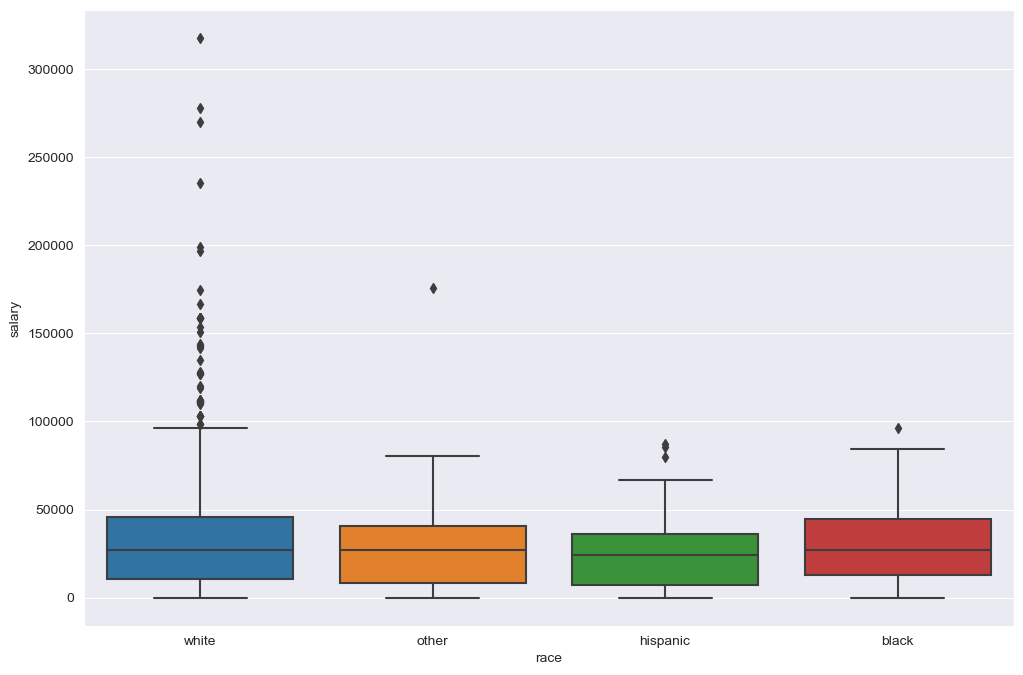

In [47]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'race', y = 'salary', data = df)

In [52]:
# Encoding
from sklearn.preprocessing import LabelEncoder

race_encode = LabelEncoder()
df['race'] = race_encode.fit_transform(df['race'])
df.head()

,race,salary
0,3,79571.29901
1,3,96396.98864
2,3,48710.66695
3,2,80478.09615
4,3,82089.34550


In [53]:
# Modeling

model = IsolationForest(n_estimators = 100, max_samples = 'auto', n_jobs = -1,
                       max_features = 2, contamination = 0.01)
model.fit(df.to_numpy())

IsolationForest(contamination=0.01, max_features=2, n_jobs=-1)

In [60]:
#df.drop('scores', axis = 1, inplace = True)

# 평가 점수
score = model.decision_function(df.to_numpy())
# 이상판단 여부
anomaly = model.predict(df.to_numpy())

df['scores'] = score
df['anomaly'] = anomaly

In [65]:
# anomaly -1인 행 선별
anomaly_data = df.loc[df['anomaly'] == -1]
anomaly_data

,race,salary,scores,anomaly
22,0,84223.39792,-0.011555,-1
202,3,198835.43390,-0.036727,-1
232,3,270275.89420,-0.077573,-1
387,3,278213.53180,-0.079154,-1
408,3,235388.71920,-0.059366,-1
436,3,174917.84850,-0.022477,-1
576,0,80502.53204,-0.010592,-1
581,1,87392.66320,-0.003511,-1
646,3,166981.02510,-0.007951,-1
690,0,96404.23538,-0.020694,-1


In [75]:
# 디코딩
anomaly_data['race'] = race_encode.inverse_transform(anomaly_data.race)

C:\Users\82104\AppData\Local\Temp\ipykernel_16656\560394162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_data['race'] = race_encode.inverse_transform(anomaly_data.race)


In [76]:
anomaly_data['race'].value_counts()

white       8
black       3
hispanic    2
other       1
Name: race, dtype: int64

<Axes: xlabel='race', ylabel='salary'>

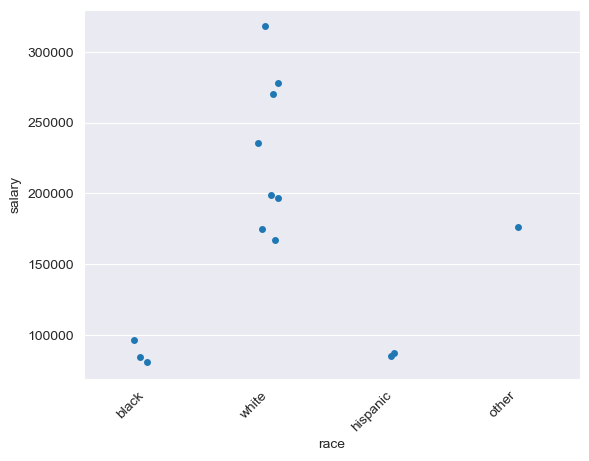

In [78]:
plt.xticks(rotation=45, horizontalalignment='right')
sns.stripplot(x = 'race', y = 'salary', data = anomaly_data, jitter = True)

In [80]:
anomaly_data[
    (anomaly_data['race'] == 'black') &
    (anomaly_data['salary'] <= 100000)
].sort_values(by = ['salary'], axis = 0)

,race,salary,scores,anomaly
576,black,80502.53204,-0.010592,-1
22,black,84223.39792,-0.011555,-1
690,black,96404.23538,-0.020694,-1
